In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#from adjustText import adjust_text

In [4]:
zoom = pd.read_excel(r"C:\Users\Admin\Documents\Studio Code\customer_retention_data\final_zoom.xlsx", dtype={'SID': str, 'SID_str': str})
goiten = pd.read_excel(r"C:\Users\Admin\Documents\Studio Code\customer_retention_data\final_goiten.xlsx", dtype={'SID_8digit':str,'SID_5digit': str})
students = pd.read_excel(r"C:\Users\Admin\Documents\Studio Code\customer_retention_data\final_student_list.xlsx", dtype={'SID_8digit':str,'SID_5digit': str})
canvas = pd.read_excel(r"C:\Users\Admin\Documents\Studio Code\customer_retention_data\final_canvas.xlsx", dtype={'SID': str})


print(students.head())
print(zoom.head())
print(goiten.head())
print(canvas.head())

c:\Users\Admin\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


         SID SID_8digit SID_5digit                  Name Grade_actual  \
0  2001-4683   20014683      14683        Tran Khanh Chi         HM 6   
1  2001-3864   20013864      13864     Nguyen Ngoc Thien         HM 6   
2  2300-3836   23003836      03836         Đào Quỳnh Anh      Grade K   
3  2300-3836   23003836      03836         Dao Quynh Anh          NaN   
4  2100-0100   21000100      00100  Nguyễn Hoàng Trúc An      Grade K   

     Grade  EFL                                  Note MVA/MVSM concat  \
0     HM 6  NaN  Found in goiten, not in student list      NaN    NaN   
1     HM 6  NaN  Found in goiten, not in student list      NaN    NaN   
2  Grade K  NaN  Found in goiten, not in student list      NaN    NaN   
3  Grade 2  NaN                                   NaN      NaN    NaN   
4  Grade K  NaN  Found in goiten, not in student list      NaN    NaN   

   4 last digits Học sinh cùng lớp có chung 4 số cuối ID           last_join  \
0            NaN                          

# Zoom dataset cleaning 

In [14]:
#take only the necessary columns 
zoom = zoom[['SID','Topic', 'ID', 'Host name', 'Host email', 'Start time', 'End time',
       'Participants', 'Duration (minutes)', 'Name (original name)', 'Email',
       'Join time', 'Leave time', 'student_stay_duration', 'Guest', 
       'date', 'time', 'day_of_week', 'hour', 'stu_join_time',
       'stu_leave_time', 'SID_str', 'role']]

#drop duplicates
zoom = zoom.drop_duplicates(subset=['ID', 'SID', 'Join time', 'Leave time', 'Name (original name)', 'student_stay_duration'], keep='last')

In [ ]:
#get student_stay_percent: because total class durations are different, we will get the percent of their stay compared to that class duration
zoom['student_stay_percent'] = (zoom['student_stay_duration']/zoom['Duration (minutes)']) *100

#get is_present: whether that class is counted as Present (student stay more than 25% of class time) or Absent (<25%)
zoom['is_present'] = (zoom['student_stay_percent']>25).astype(int)

#get minutes_late & minutes leaving early
#turn into datetime formats
zoom['Start time'] = pd.to_datetime(zoom['Start time'])
zoom['End time'] = pd.to_datetime(zoom['End time'])
zoom['Join time'] = pd.to_datetime(zoom['Join time'])
zoom['Leave time'] = pd.to_datetime(zoom['Leave time'])

#get minutes late
zoom['minutes_late'] = round((zoom['Join time']-zoom['Start time']).dt.total_seconds()/60)

#get minutes leaving early
zoom['minutes_leave_early'] = round((zoom['End time']-zoom['Leave time']).dt.total_seconds()/60)

minutes_leave_early
0.0     177291
1.0      15813
2.0       4712
4.0       4142
3.0       3978
         ...  
89.0         6
88.0         5
90.0         3
91.0         1
94.0         1
Name: count, Length: 95, dtype: int64

In [ ]:
# Since the organization has open-enrolling system, 
# meaning new students can be admitted any time of the year, 
# their total sessions are different

#Get Student's first and last join sessions
student_join_stats = (zoom.groupby('SID', as_index=False).agg(
    first_join=('Join time', 'min'),
    last_join=('Join time', 'max'),
    last_leave=('Leave time', 'max')
))

student_join_stats

,SID,first_join,last_join,last_leave
0,00000006,2025-02-20 18:25:00,2025-05-29 18:25:00,2025-05-29 19:15:00
1,00000042,2025-02-04 19:26:00,2025-05-29 19:38:00,2025-05-29 20:03:00
2,00000044,2025-02-04 20:46:00,2025-02-18 20:28:00,2025-02-18 20:31:00
3,00000077,2025-02-10 18:40:00,2025-05-29 20:26:00,2025-05-29 21:09:00
4,00000092,2025-01-17 20:04:00,2025-01-17 20:04:00,2025-01-17 20:25:00
...,...,...,...,...
1775,25000288,2025-05-15 18:31:00,2025-05-29 18:29:00,2025-05-29 19:25:00
1776,25000319,2025-04-17 19:10:00,2025-04-21 18:43:00,2025-04-21 19:25:00
1777,25000331,2025-04-21 19:52:00,2025-05-13 19:33:00,2025-05-13 19:42:00
1778,25000396,2025-05-05 18:26:00,2025-05-22 18:28:00,2025-05-22 19:25:00


# Goiten dataset cleaning

In [69]:
goiten = pd.read_excel(r"C:\Users\Admin\Documents\Studio Code\customer_retention_data\final_goiten.xlsx", dtype={'SID_8digit':str,'SID_5digit': str})
goiten.head()

,SID_full,SID_8digit,SID_5digit,Name,Grade,Call,percent_response,success_call,no_resp_calls,Successful,No_response
0,1904-0019,19040019,40019,Hoàng Gia An,Grade 9,0,0.0,0,0,NaN,NaN
1,1904-0019,19040019,40019,Hoàng Gia An,EFL 69,0,0.0,0,0,NaN,NaN
2,1904-0020,19040020,40020,Hoàng Khải Lâm,Grade 9,0,0.0,0,0,NaN,NaN
3,1904-0020,19040020,40020,Hoàng Khải Lâm,EFL 69,0,0.0,0,0,NaN,NaN
4,1904-0024,19040024,40024,Lê Hà Thu,Grade 9,0,0.0,0,0,NaN,NaN


In [70]:
#fill NAs in the Successful and No_response column as 0 (representing not called on)
goiten['Successful'] = goiten['Successful'].fillna(0)
goiten['No_response'] = goiten['No_response'].fillna(0)

In [71]:
#get relative_rank: 
# since different classes have different student_call/participation levels,
# we will get the percentile of that record for that specific class to normalize
goiten['relative_rank'] = (goiten.groupby('Grade')['Call'].rank(pct=True) *100)

goiten.head()

,SID_full,SID_8digit,SID_5digit,Name,Grade,Call,percent_response,success_call,no_resp_calls,Successful,No_response,relative_rank
0,1904-0019,19040019,40019,Hoàng Gia An,Grade 9,0,0.0,0,0,0,0,50.925926
1,1904-0019,19040019,40019,Hoàng Gia An,EFL 69,0,0.0,0,0,0,0,41.654357
2,1904-0020,19040020,40020,Hoàng Khải Lâm,Grade 9,0,0.0,0,0,0,0,50.925926
3,1904-0020,19040020,40020,Hoàng Khải Lâm,EFL 69,0,0.0,0,0,0,0,41.654357
4,1904-0024,19040024,40024,Lê Hà Thu,Grade 9,0,0.0,0,0,0,0,50.925926


# Canvas (quiz) dataset cleaning

In [38]:
canvas.head()

,ID,SID,Student,Section,Quiz,Score,Source_File,Quiz_Clean
0,10424,23003601,Bui Hoang Bach - 23003601,Grade 8 Algebra I F2024,1.1 Linear Functions (78170),100.0,2025-09-06T0348_Grades-Grade_8_Algebra_I_F2024,1.1 Linear Functions
1,3336,20034287,Bùi Lê Thảo Nguyên - 20034287,Grade 8 Algebra I F2024,1.1 Linear Functions (78170),NaN,2025-09-06T0348_Grades-Grade_8_Algebra_I_F2024,1.1 Linear Functions
2,9599,22001282,Bùi Trần Bảo Minh - 22001282,Grade 8 Algebra I F2024,1.1 Linear Functions (78170),100.0,2025-09-06T0348_Grades-Grade_8_Algebra_I_F2024,1.1 Linear Functions
3,2986,20043685,Bùi Vũ Gia Linh - 20043685,Grade 8 Algebra I F2024,1.1 Linear Functions (78170),100.0,2025-09-06T0348_Grades-Grade_8_Algebra_I_F2024,1.1 Linear Functions
4,10863,23000899,Cao Quỳnh Lam - 23000899,Grade 8 Algebra I F2024,1.1 Linear Functions (78170),NaN,2025-09-06T0348_Grades-Grade_8_Algebra_I_F2024,1.1 Linear Functions


In [43]:
quiz_stats = (canvas.groupby(['SID', 'Section'], as_index=False).agg(
    n_quizzess_avail=('Quiz', 'nunique'),
    n_quizzess_done=('Score', lambda x: x.notna().sum()),
    total_marks=('Score', 'sum'),
    mean_score=('Score', 'mean')
))

quiz_stats.head(10)
#the long strings SID are from the developper to test
#the emails in SIDs are from teachers/TAs

,SID,Section,n_quizzess_avail,n_quizzess_done,total_marks,mean_score
0,022935959780e30bdb2f1b2714afbb371922023c,Grade 7 Geography SP2025,24,6,0.00,0.000000
1,0a1a38604e002a657e3e774544b382a66db7defc,Grade 8 Algebra I F2024,57,11,101.68,9.243636
2,14837667e621e6f9fc6181fda599e6667e7f727c,Grade 3 Humanities F2024,22,11,0.00,0.000000
3,14d487bdf6e813c2a9b02c99cf14aae3c87349df,Grade 6 Earth Science F2024,112,6,0.00,0.000000
4,184c89d61a0a6a7b7e9a6ec9edb888e4572b4211,Grade 2 Math Spring 2025,45,6,0.00,0.000000
5,19040019,AP Biology F2024,42,39,1659.96,42.563077
6,19040019,AP Biology SP2025,44,38,1748.74,46.019474
7,19040020,AP Biology F2024,42,42,1796.79,42.780714
8,19040020,AP Biology SP2025,44,44,2655.88,60.360909
9,19040024,AP Biology F2024,42,35,1506.10,43.031429


In [49]:
#get avg_score2_all_quizzes: total marks divided all 
quiz_stats['avg_score1_all_quizzes'] = (
    quiz_stats['total_marks'] / quiz_stats['n_quizzess_avail']
)

#because in some class, there are quizzes that are optional 
#so students rarely do them -> we cannot take total marks / total_quizzes (a lot will be nulls)
#get avg_score2_done_quizzes: total marks / the quizzes done only
quiz_stats['avg_score2_done_quizzes'] = (
    quiz_stats['total_marks'] / quiz_stats['n_quizzess_done']
)

#because some classes have different quiz scale (e.g., 100 vs 20)
#get percentile of that student's score compared to the rest in that class (normalize)
quiz_stats['score_percentile1'] = (
    quiz_stats.groupby('Section')['avg_score1_all_quizzes']
    .rank(pct=True)*100
)

quiz_stats['score_percentile2'] = (
    quiz_stats.groupby('Section')['avg_score2_done_quizzes']
    .rank(pct=True)*100
)

#get completion_rate
quiz_stats['percent_completion'] = (
    quiz_stats['n_quizzess_done'] / quiz_stats['n_quizzess_avail'] 
)*100

quiz_stats.head(10)

,SID,Section,n_quizzess_avail,n_quizzess_done,total_marks,mean_score,avg_score1_all_quizzes,avg_score2_done_quizzes,score_percentile1,score_percentile2,percent_completion
0,022935959780e30bdb2f1b2714afbb371922023c,Grade 7 Geography SP2025,24,6,0.00,0.000000,0.000000,0.000000,12.681159,12.681159,25.000000
1,0a1a38604e002a657e3e774544b382a66db7defc,Grade 8 Algebra I F2024,57,11,101.68,9.243636,1.783860,9.243636,41.269841,41.269841,19.298246
2,14837667e621e6f9fc6181fda599e6667e7f727c,Grade 3 Humanities F2024,22,11,0.00,0.000000,0.000000,0.000000,12.931034,12.931034,50.000000
3,14d487bdf6e813c2a9b02c99cf14aae3c87349df,Grade 6 Earth Science F2024,112,6,0.00,0.000000,0.000000,0.000000,16.250000,16.250000,5.357143
4,184c89d61a0a6a7b7e9a6ec9edb888e4572b4211,Grade 2 Math Spring 2025,45,6,0.00,0.000000,0.000000,0.000000,10.663507,10.663507,13.333333
5,19040019,AP Biology F2024,42,39,1659.96,42.563077,39.522857,42.563077,84.571429,71.428571,92.857143
6,19040019,AP Biology SP2025,44,38,1748.74,46.019474,39.744091,46.019474,88.028169,81.690141,86.363636
7,19040020,AP Biology F2024,42,42,1796.79,42.780714,42.780714,42.780714,96.571429,73.142857,100.000000
8,19040020,AP Biology SP2025,44,44,2655.88,60.360909,60.360909,60.360909,98.591549,97.887324,100.000000
9,19040024,AP Biology F2024,42,35,1506.10,43.031429,35.859524,43.031429,74.285714,73.714286,83.333333


# Aggregrate metrics, grouped by SIDs

In [ ]:
#aggregate zoom dataset -> by SID
zoom_agg = (
    zoom.groupby('SID', as_index=False)
    .agg(
        late_mins=('minutes_late', 'mean'),
        leave_early_mins=('minutes_leave_early','mean'),
        duration=('student_stay_duration','mean'),
        duration_pct=('student_stay_percent','mean'),
        present_sessions=('is_present', 'sum'),
        joined_sessions=('ID', 'nunique'),
        duration_std=('student_stay_duration','std'),
    )
)

zoom_agg

,SID,late_mins,leave_early_mins,duration,duration_pct,present_sessions,joined_sessions,duration_std
0,00000006,6.527473,13.219780,41.054945,67.652918,78,49,17.648647
1,00000042,6.590476,5.390476,48.104762,79.415525,92,60,19.146663
2,00000044,7.000000,30.333333,13.333333,25.806435,1,3,15.307950
3,00000077,6.942149,2.661157,46.173554,83.030170,116,48,11.920345
4,00000092,37.000000,0.000000,22.000000,37.931034,1,1,NaN
...,...,...,...,...,...,...,...,...
1775,25000288,11.875000,7.750000,40.500000,67.514969,7,3,19.856629
1776,25000319,25.600000,19.600000,14.400000,24.000000,1,2,15.820872
1777,25000331,13.600000,19.400000,26.100000,44.137931,8,4,14.594139
1778,25000396,3.615385,2.846154,53.615385,88.619100,13,6,10.743513


In [72]:
#aggregrate goiten
goiten['SID_8digit'] = goiten['SID_8digit'].astype(str).str.strip()

goiten_agg = (
    goiten.groupby('SID_8digit', as_index=False)
    .agg(
        called_on_days=('Call', 'sum'),
        response_pct=('percent_response','mean'),
        success_call_days=('success_call', 'sum'),
        call_pctile=('relative_rank', 'mean')
    )
)

goiten_agg

,SID_8digit,called_on_days,response_pct,success_call_days,call_pctile
0,19040015,0,0.000000,0,18.518519
1,19040019,0,0.000000,0,46.290142
2,19040020,0,0.000000,0,46.290142
3,19040024,0,0.000000,0,46.290142
4,19040025,0,0.000000,0,46.290142
...,...,...,...,...,...
2328,25000385,1,100.000000,1,25.468165
2329,25000392,3,100.000000,3,41.198502
2330,25000396,0,0.000000,0,14.565217
2331,25000506,0,0.000000,0,9.925094


In [ ]:
#aggregrate quiz_stats
#aggregrate quiz
quiz_agg = (
    quiz_stats.groupby('SID', as_index=False)
    .agg(
        score_avg_1=('avg_score1_all_quizzes', 'mean'),
        score_avg_2=('avg_score2_done_quizzes', 'mean'),
        score_avg_1_pctile=('score_percentile1', 'mean'),
        score_avg_2_pctile=('score_percentile2','mean'),
        quiz_completion_pct=('percent_completion','mean')
    )
)

quiz_agg.head(10)

,SID,score_avg_1,score_avg_2,score_avg_1_pctile,score_avg_2_pctile,quiz_completion_pct
0,022935959780e30bdb2f1b2714afbb371922023c,0.000000,0.000000,12.681159,12.681159,25.000000
1,0a1a38604e002a657e3e774544b382a66db7defc,1.783860,9.243636,41.269841,41.269841,19.298246
2,14837667e621e6f9fc6181fda599e6667e7f727c,0.000000,0.000000,12.931034,12.931034,50.000000
3,14d487bdf6e813c2a9b02c99cf14aae3c87349df,0.000000,0.000000,16.250000,16.250000,5.357143
4,184c89d61a0a6a7b7e9a6ec9edb888e4572b4211,0.000000,0.000000,10.663507,10.663507,13.333333
5,19040019,39.633474,44.291275,86.299799,76.559356,89.610390
6,19040020,51.570812,51.570812,97.581489,85.515091,100.000000
7,19040024,45.152751,54.777384,81.269850,77.886792,82.855095
8,19040025,9.943826,25.906905,39.413692,39.953306,30.112418
9,19040026,22.019682,50.762121,64.223623,72.600853,43.623737


# Merge into 1 master dataset

In [73]:
student_full = (
    students
    .merge(zoom_agg, left_on='SID_8digit', right_on='SID', how='left')
    .merge(quiz_agg, left_on='SID_8digit', right_on='SID', how='left')
    .merge(goiten_agg, on='SID_8digit', how='left')
)

student_full

,SID_x,SID_8digit,SID_5digit,Name,Grade_actual,Grade,EFL,Note,MVA/MVSM,concat,...,SID,score_avg_1,score_avg_2,score_avg_1_pctile,score_avg_2_pctile,quiz_completion_pct,called_on_days,response_pct,success_call_days,call_pctile
0,2001-4683,20014683,14683,Tran Khanh Chi,HM 6,HM 6,NaN,"Found in goiten, not in student list",NaN,NaN,...,20014683,95.209587,96.129999,92.352679,91.831845,98.985390,2.0,50.0,2.0,55.771930
1,2001-3864,20013864,13864,Nguyen Ngoc Thien,HM 6,HM 6,NaN,"Found in goiten, not in student list",NaN,NaN,...,20013864,17.972784,40.490709,37.875000,37.375000,34.004386,3.0,50.0,3.0,58.534361
2,2300-3836,23003836,03836,Đào Quỳnh Anh,Grade K,Grade K,NaN,"Found in goiten, not in student list",NaN,NaN,...,23003836,0.000000,0.000000,16.576087,16.576087,21.428571,1.0,100.0,1.0,28.773585
3,2300-3836,23003836,03836,Dao Quynh Anh,NaN,Grade 2,NaN,NaN,NaN,NaN,...,23003836,0.000000,0.000000,16.576087,16.576087,21.428571,1.0,100.0,1.0,28.773585
4,2100-0100,21000100,00100,Nguyễn Hoàng Trúc An,Grade K,Grade K,NaN,"Found in goiten, not in student list",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,75.0,3.0,41.981132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,0003-3212,00033212,33212,Nguyen Ngoc Nhu Anh 33212,NaN,Grade 8,NaN,no match in list student but has zoom act,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1779,0003-3549,00033549,33549,Pham Bui Khai An 33549,NaN,HM 6,NaN,no match in list student but has zoom act,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1780,0005-4490,00054490,54490,Nguyen Thao Binh 54490,NaN,EFL 3 - 5,NaN,no match in list student but has zoom act,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1781,0006-0077,00060077,60077,Nguyen Nam Khanh 60077,NaN,Grade 9-12,NaN,no match in list student but has zoom act,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
student_full.to_csv('master_file1.csv', index=False)

# EDA

In [83]:
df = pd.read_csv(r"C:\Users\Admin\Documents\Studio Code\customer_retention_project\master_file1.csv", dtype={'SID':str})
df.head()

,SID,Grade,late_mins,leave_early_mins,duration,duration_pct,present_sessions,joined_sessions,duration_std,score_avg_1,...,score_avg_1_pctile,score_avg_2_pctile,quiz_completion_pct,has_quiz_data,called_on_days,response_pct,success_call_days,call_pctile,days_to_end,dropout
0,25000044,Grade 3,7.000000,30.333333,13.333333,25.806435,1,3,15.307950,NaN,...,NaN,NaN,NaN,0,4,100.0,4,78.779600,101,True
1,00002547,EFL K5,1.941176,2.220588,56.147059,93.033927,66,34,10.591837,NaN,...,NaN,NaN,NaN,0,4,100.0,4,78.779600,1,False
2,19040015,Grade 3,8.945205,3.931507,42.616438,77.144979,63,30,17.122622,NaN,...,NaN,NaN,NaN,0,0,0.0,0,18.518519,190,True
3,19040020,Grade 9-12,10.454545,4.636364,43.090909,74.119517,10,9,16.706014,51.570812,...,97.581489,85.515091,100.000000,1,0,0.0,0,46.290142,114,True
4,19040024,Grade 9-12,10.326316,9.926316,40.031579,66.734364,79,55,18.633904,45.152751,...,81.269850,77.886792,82.855095,1,0,0.0,0,46.290142,7,False


In [87]:
# Info
print("\n--- Dataset info ---")
df.info()

# Numeric summary
print("\n--- Numeric summary ---")
print(df.describe().T)

# Missing-value
print("\n--- Missing values ---")
na_count = df.isna().sum()
na_percent = (na_count / len(df)) * 100
missing = pd.DataFrame({'Missing_Count': na_count, 'Missing_%': na_percent})
print(missing.sort_values('Missing_%', ascending=False))

# Duplicate check 
dupes = df.duplicated(subset='SID').sum()
print(f"\n--- Duplicate SIDs: {dupes}")

# Uniqueness check
print(f"Unique SIDs: {df['SID'].nunique()} / Total rows: {len(df)}")

# Categorical check
cat_cols = df.select_dtypes('object').columns
for col in cat_cols:
    unique_vals = df[col].nunique(dropna=False)
    print(f"{col:<25} | unique values: {unique_vals}")


--- Dataset info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1658 entries, 0 to 1657
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SID                  1658 non-null   object 
 1   Grade                1658 non-null   object 
 2   late_mins            1658 non-null   float64
 3   leave_early_mins     1658 non-null   float64
 4   duration             1658 non-null   float64
 5   duration_pct         1658 non-null   float64
 6   present_sessions     1658 non-null   int64  
 7   joined_sessions      1658 non-null   int64  
 8   duration_std         1637 non-null   float64
 9   score_avg_1          1581 non-null   float64
 10  score_avg_2          1581 non-null   float64
 11  score_avg_1_pctile   1581 non-null   float64
 12  score_avg_2_pctile   1581 non-null   float64
 13  quiz_completion_pct  1581 non-null   float64
 14  has_quiz_data        1658 non-null   int64  
 15  called_on_days  

In [89]:
df.columns

Index(['SID', 'Grade', 'late_mins', 'leave_early_mins', 'duration',
       'duration_pct', 'present_sessions', 'joined_sessions', 'duration_std',
       'score_avg_1', 'score_avg_2', 'score_avg_1_pctile',
       'score_avg_2_pctile', 'quiz_completion_pct', 'has_quiz_data',
       'called_on_days', 'response_pct', 'success_call_days', 'call_pctile',
       'days_to_end', 'dropout'],
      dtype='object')

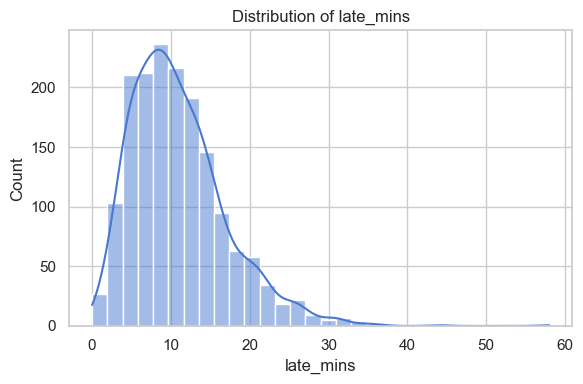

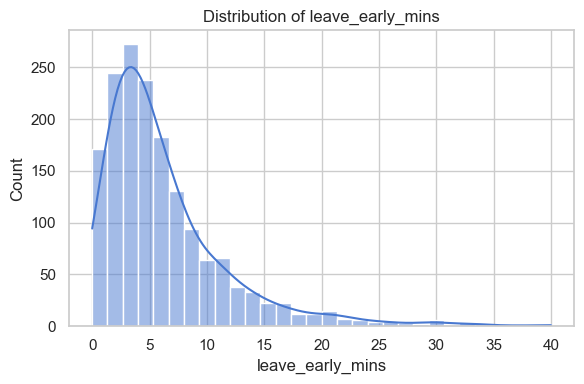

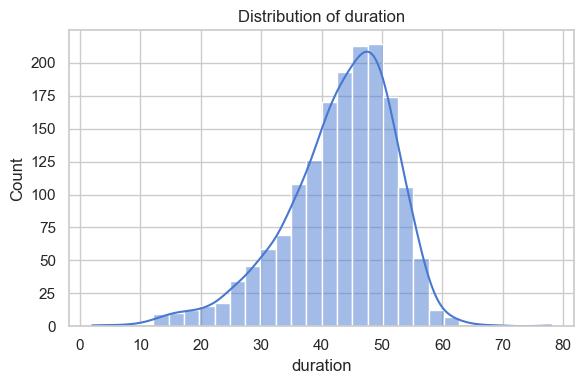

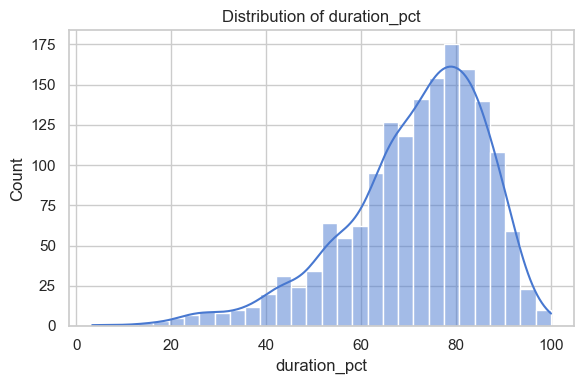

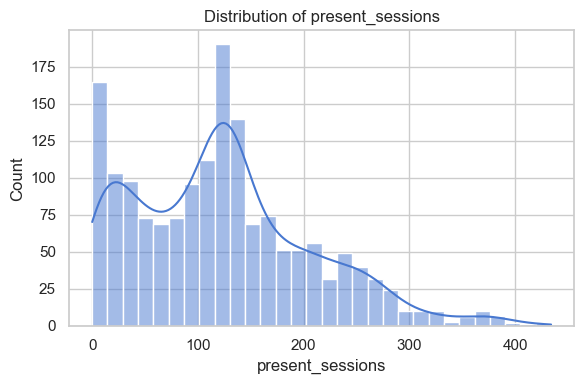

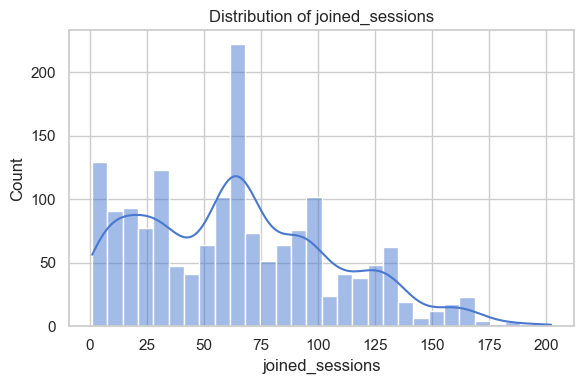

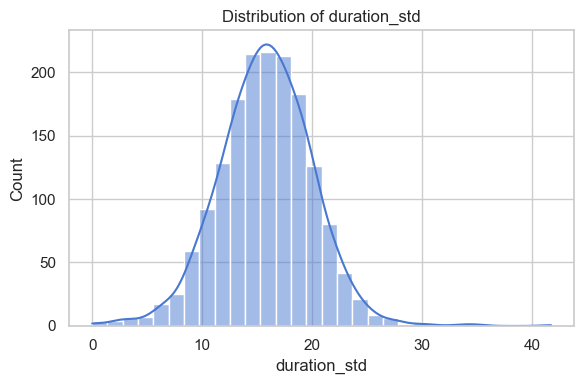

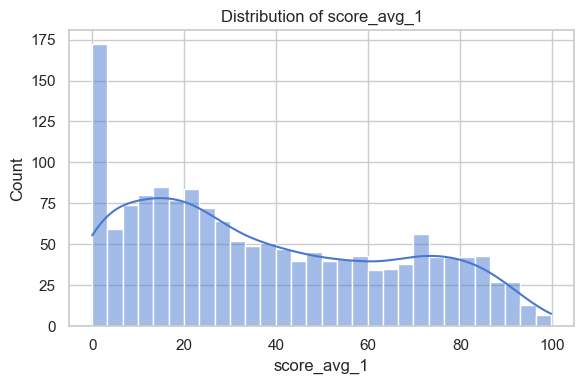

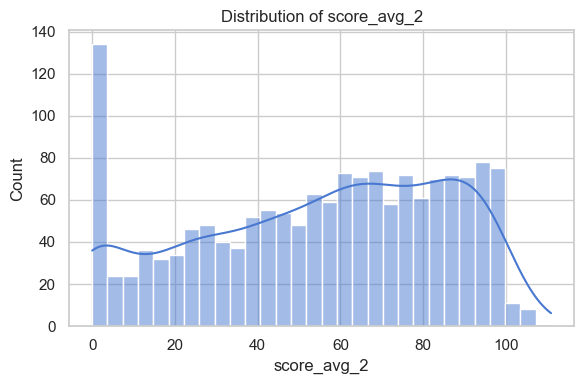

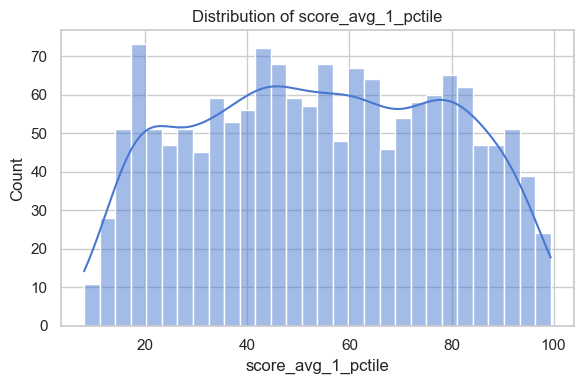

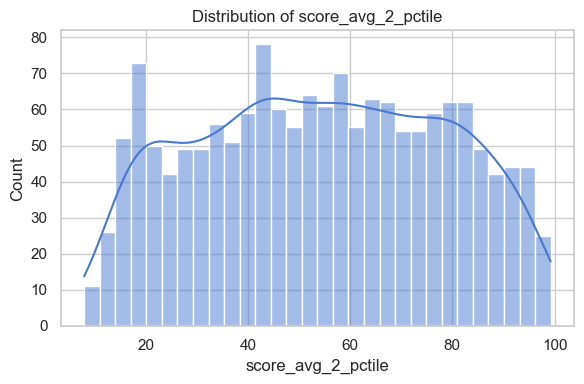

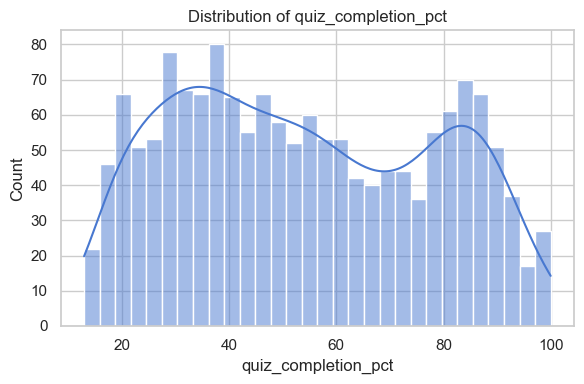

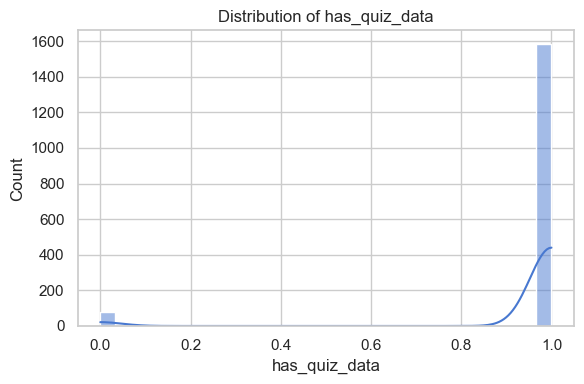

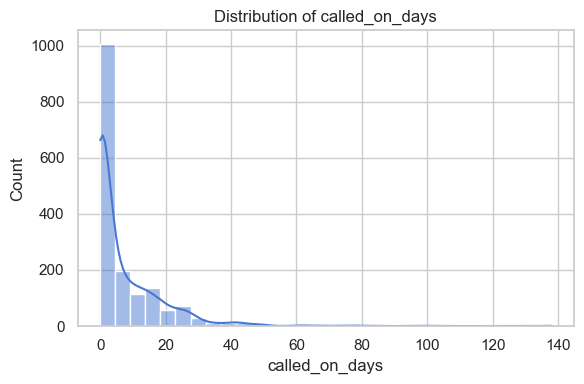

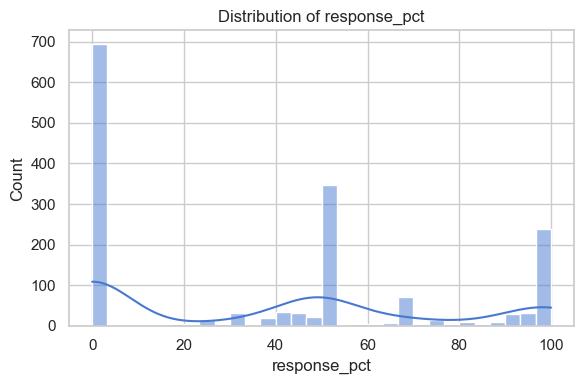

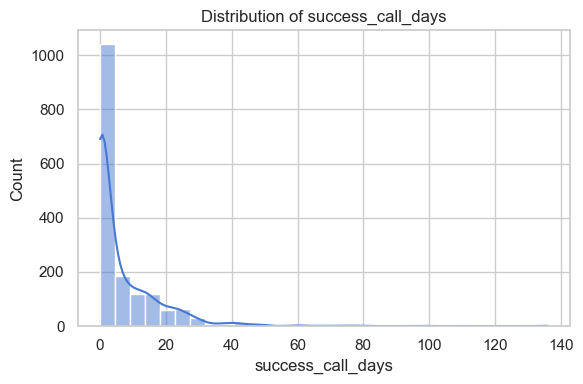

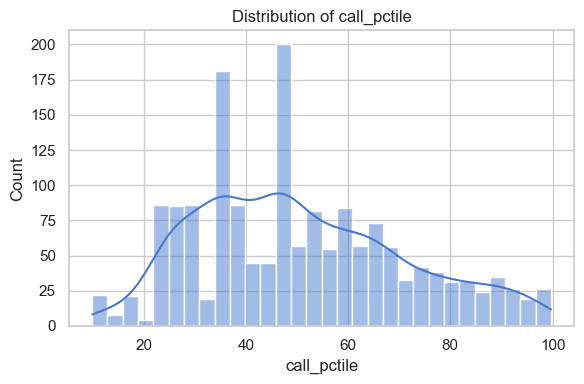

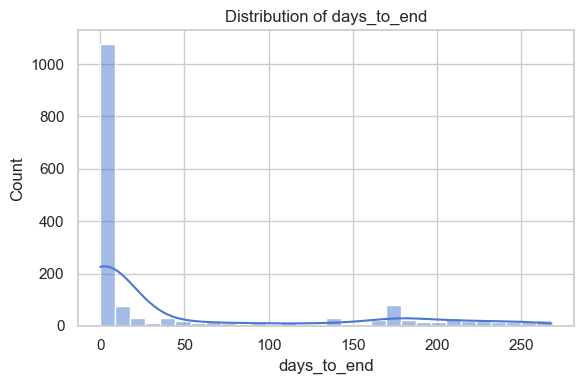

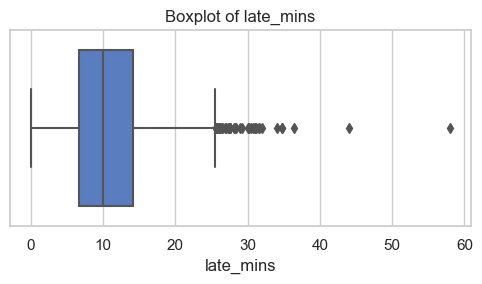

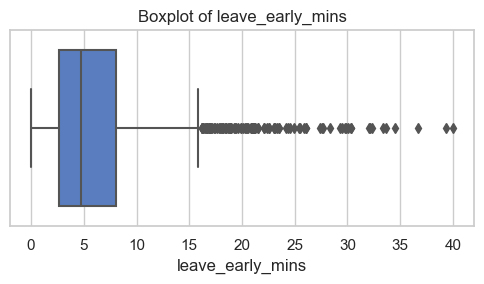

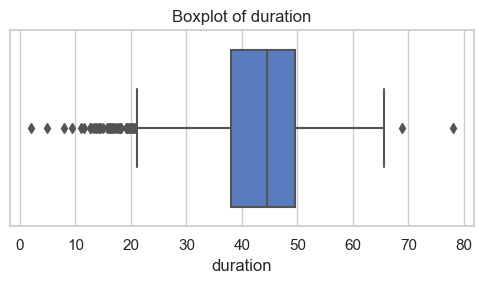

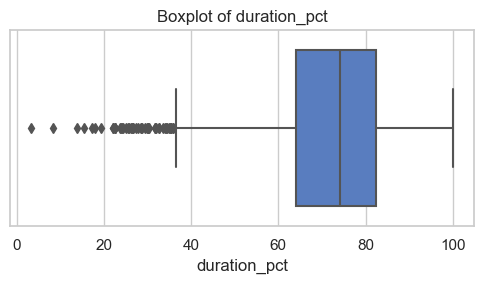

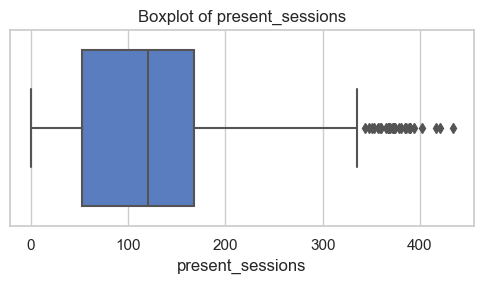

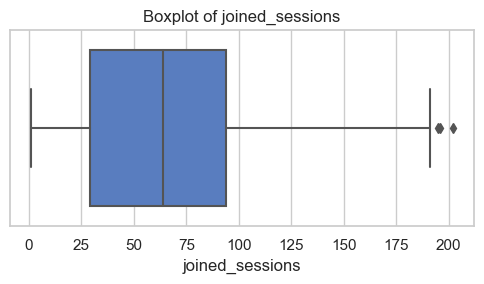

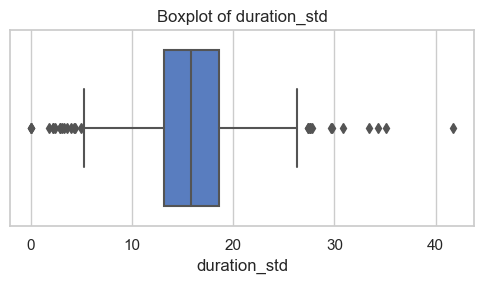

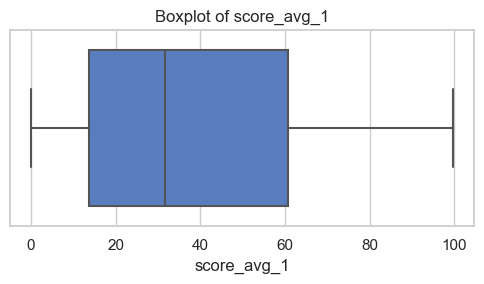

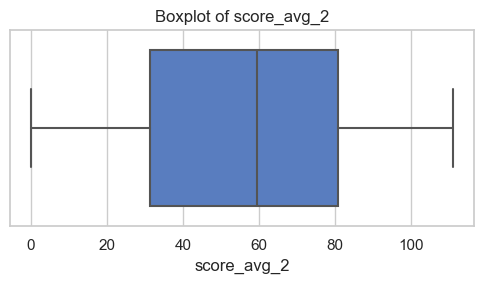

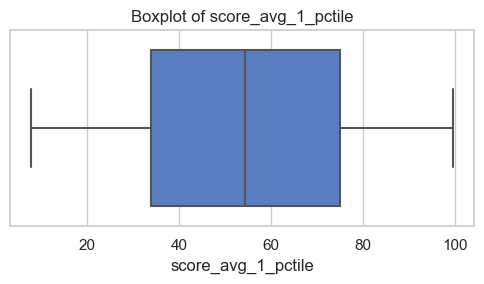

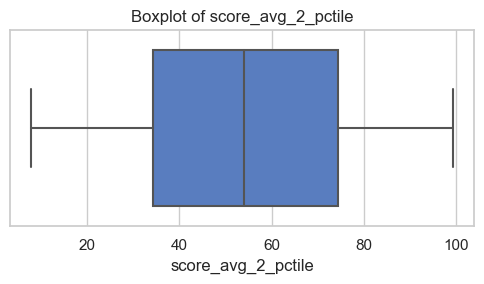

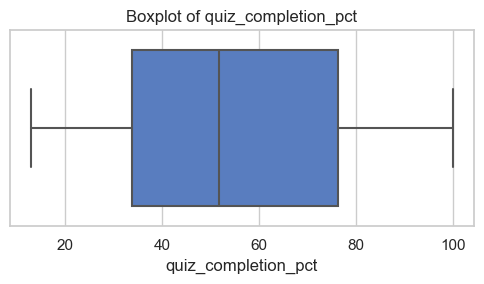

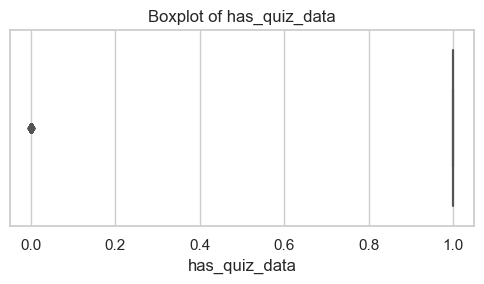

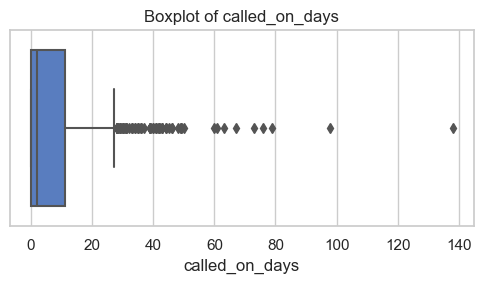

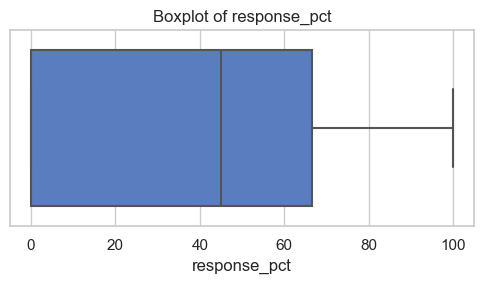

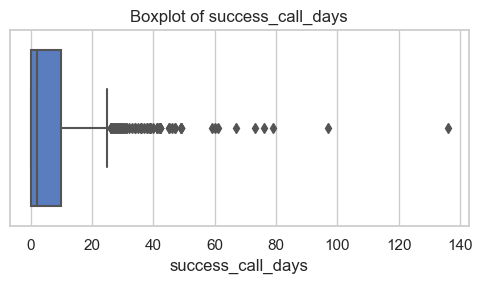

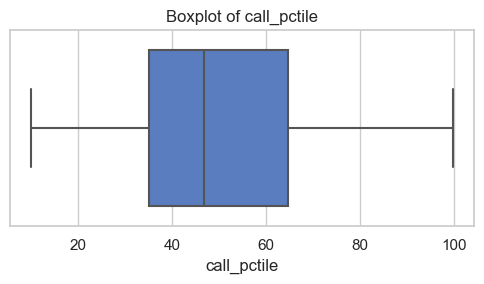

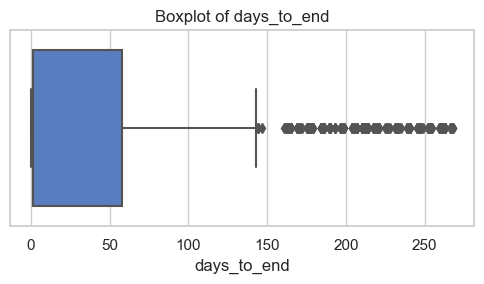

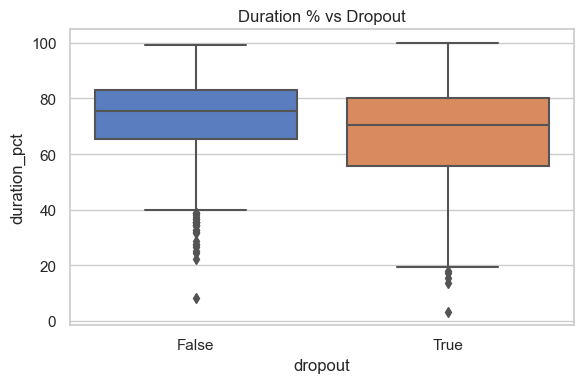

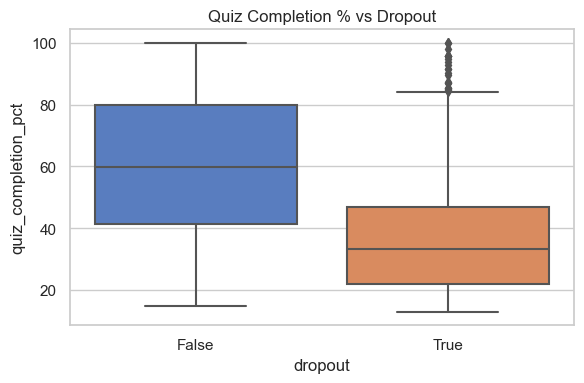

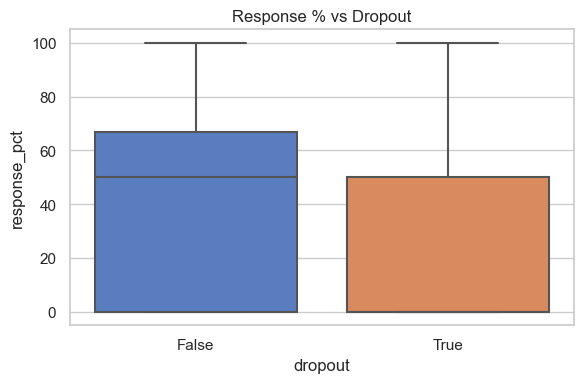

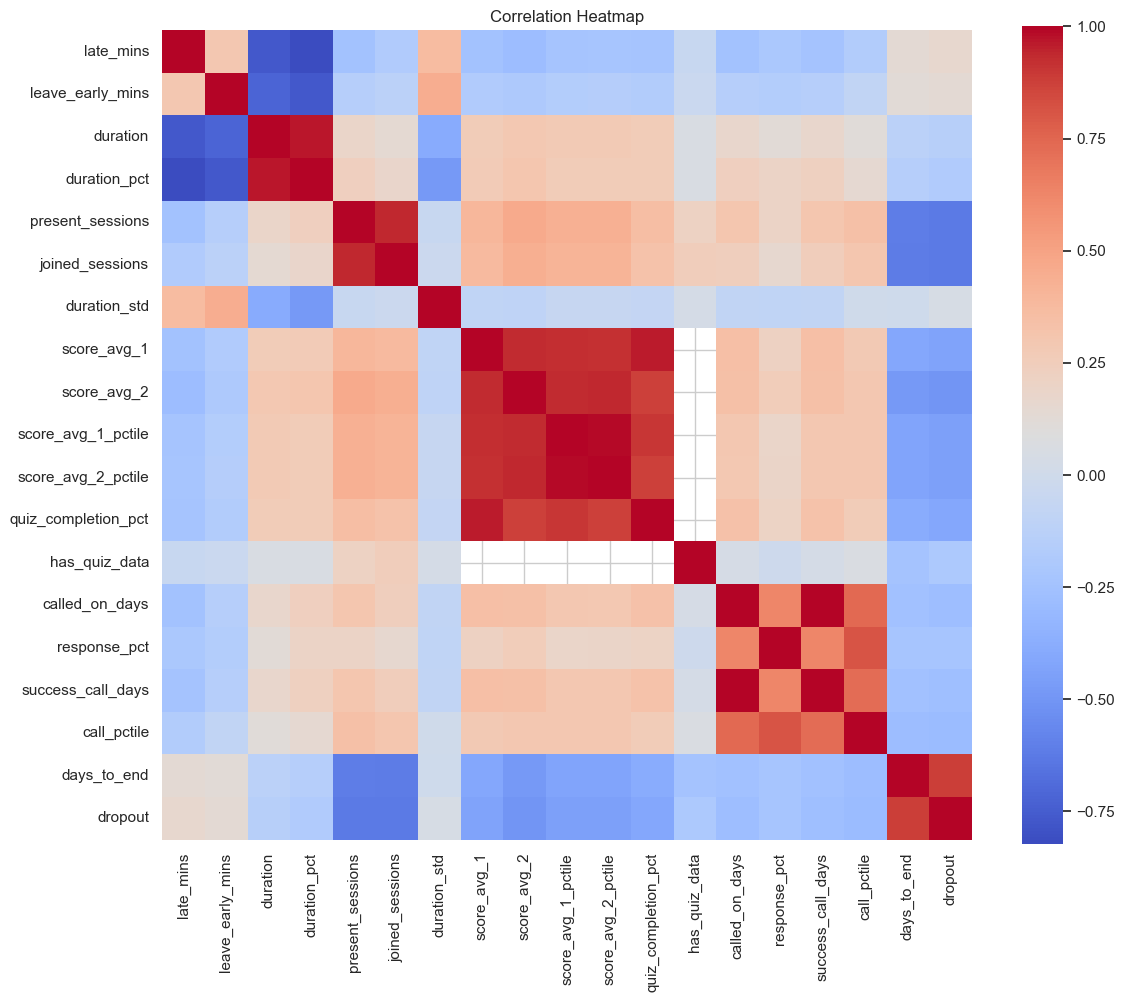

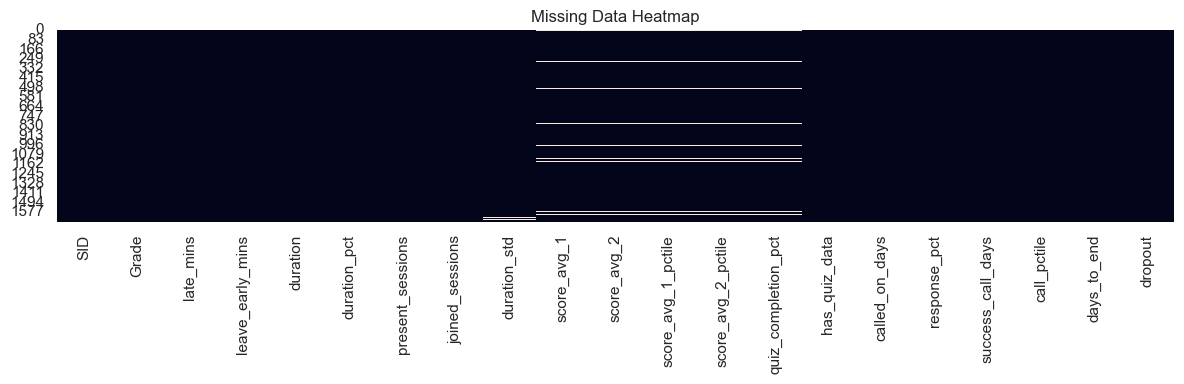

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="muted")

# ✅ numeric columns (exclude SID, Grade, dropout)
num_cols = [
    'late_mins', 'leave_early_mins', 'duration', 'duration_pct',
    'present_sessions', 'joined_sessions', 'duration_std',
    'score_avg_1', 'score_avg_2', 'score_avg_1_pctile',
    'score_avg_2_pctile', 'quiz_completion_pct', 'has_quiz_data',
    'called_on_days', 'response_pct', 'success_call_days',
    'call_pctile', 'days_to_end'
]

# 1️⃣  Univariate distributions
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# 2️⃣  Boxplots for outliers
for col in num_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()
    plt.show()

# 3️⃣  Relationship with dropout
plt.figure(figsize=(6,4))
sns.boxplot(x='dropout', y='duration_pct', data=df)
plt.title("Duration % vs Dropout")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='dropout', y='quiz_completion_pct', data=df)
plt.title("Quiz Completion % vs Dropout")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='dropout', y='response_pct', data=df)
plt.title("Response % vs Dropout")
plt.tight_layout()
plt.show()

# 4️⃣  Correlation heatmap
corr = df[num_cols + ['dropout']].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", annot=False, fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# 5️⃣  Missingness heatmap
plt.figure(figsize=(12,4))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Data Heatmap")
plt.tight_layout()
plt.show()
